# Everything is on the cloud now and I feel numb

In [120]:
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [121]:
# the location of our credentials json and name of bigquery project
credentials = service_account.Credentials.from_service_account_file('C:\\Users\\elija\\Documents\\24f-coop\\credentials.json')
project = 'net-data-viz-handbook'

# Initialize a GCS client
client = bigquery.Client(credentials=credentials, project=project)

## Getting df_pivot for graphing porpoises

In [122]:
# df_pivot just because it's nice to have
query_pivot = """
SELECT *
FROM (
    SELECT 
        date,
        country_id,
        run_id,
        SUM(Infectious_13_17 + Infectious_18_23) AS total_infectious
    FROM `net-data-viz-handbook.sri_data.SIR_0_countries_incidence_daily`
    WHERE country_id IN (215)
      AND run_id BETWEEN 1 AND 100
    GROUP BY date, country_id, run_id
)
PIVOT (
    SUM(total_infectious) FOR run_id IN (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
                                         21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
                                         41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 
                                         61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 
                                         81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100)
)
ORDER BY date;
"""

In [123]:
# Run the query
query_job = client.query(query_pivot)

# Fetch the results into a DataFrame
df_pivot = query_job.to_dataframe()

del df_pivot['country_id']
df_pivot.set_index('date', inplace=True)

df_pivot.columns = df_pivot.columns.str.replace('_', '', regex=False).astype(int)

# Display the first few rows
df_pivot.head()

C:\Users\elija\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
date,,,,,,,,,,,,,,,,,,,,,
2009-02-17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-02-18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-02-19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-02-20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-02-21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## KMeans and a prayer

In [124]:
# Set parameters for the K-means model
num_clusters = 3  # Example number of clusters

# Step 1: Create the MSE matrix table
query_mse_matrix = """
CREATE OR REPLACE TABLE `sri_data.mse_matrix` AS
WITH infectious_data AS (
    SELECT
        date,
        country_id,
        run_id,
        SUM(Infectious_13_17 + Infectious_18_23) AS total_infectious
    FROM
        `net-data-viz-handbook.sri_data.SIR_0_countries_incidence_daily`
    WHERE
        country_id IN (215) AND run_id BETWEEN 1 AND 100
    GROUP BY
        date,
        country_id,
        run_id
)
SELECT
    a.run_id AS run_id_a,
    b.run_id AS run_id_b,
    AVG(POW(a.total_infectious - b.total_infectious, 2)) AS mse
FROM
    infectious_data a
JOIN
    infectious_data b
ON
    a.date = b.date
GROUP BY
    run_id_a, run_id_b
"""
client.query(query_mse_matrix).result()  # Execute the query to create the table
print("MSE matrix table created successfully.")

# Step 2: Create the ABC matrix table
query_abc_matrix = """
CREATE OR REPLACE TABLE `sri_data.abc_matrix` AS
WITH infectious_data AS (
    SELECT
        date,
        country_id,
        run_id,
        SUM(Infectious_13_17 + Infectious_18_23) AS total_infectious
    FROM
        `net-data-viz-handbook.sri_data.SIR_0_countries_incidence_daily`
    WHERE
        country_id IN (215) AND run_id BETWEEN 1 AND 100
    GROUP BY
        date,
        country_id,
        run_id
)
SELECT
    a.run_id AS run_id_a,
    b.run_id AS run_id_b,
    SUM(ABS(a.total_infectious - b.total_infectious)) AS abc
FROM
    infectious_data a
JOIN
    infectious_data b
ON
    a.date = b.date
GROUP BY
    run_id_a, run_id_b
"""
client.query(query_abc_matrix).result()  # Execute the query to create the table
print("ABC matrix table created successfully.")

# Step 3: Create the distance matrix
query_distance_matrix = """
CREATE OR REPLACE TABLE `sri_data.distance_matrix` AS
SELECT
    run_id_a AS run_id,
    ARRAY_AGG(STRUCT(run_id_b, mse) ORDER BY run_id_b ASC) AS distances
FROM
    `sri_data.mse_matrix`
GROUP BY
    run_id_a;
"""
client.query(query_distance_matrix).result()  # Execute the query to create the table
print("Distance matrix table created successfully.")

# Step 4: Create the K-means model with fixed random feature selection
query_create_model = f"""
CREATE OR REPLACE MODEL `sri_data.kmeans_model`
OPTIONS(model_type='kmeans', num_clusters={num_clusters}) AS
WITH indexed_distances AS (
    SELECT
        run_id,
        distance,
        ROW_NUMBER() OVER (PARTITION BY run_id ORDER BY distance.run_id_b) AS rn
    FROM
        `sri_data.distance_matrix`,
        UNNEST(distances) AS distance
)
SELECT
    run_id,
    ARRAY_AGG(distance ORDER BY rn) AS features
FROM
    indexed_distances
GROUP BY
    run_id;
"""
client.query(query_create_model).result()  # Execute the model creation
print("K-means model created successfully.")

# Step 5: Apply K-means clustering using the model
query_kmeans = f"""
SELECT
    *
FROM
    ML.PREDICT(MODEL `sri_data.kmeans_model`,
        (SELECT
            run_id,
            ARRAY_AGG(distance ORDER BY rn) AS features
         FROM (
            SELECT
                run_id,
                distance,
                ROW_NUMBER() OVER (PARTITION BY run_id ORDER BY distance.run_id_b) AS rn
            FROM
                `sri_data.distance_matrix`,
                UNNEST(distances) AS distance
         )
         GROUP BY
            run_id)
    ) AS predictions;
"""
kmeans_result = client.query(query_kmeans).to_dataframe()  # Execute and fetch results
print("K-means clustering applied successfully.")

MSE matrix table created successfully.
ABC matrix table created successfully.
Distance matrix table created successfully.
K-means model created successfully.


C:\Users\elija\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


K-means clustering applied successfully.


In [127]:
kmeans_result.features[0]

array([{'run_id_b': 1, 'mse': 32294617.013661206},
       {'run_id_b': 2, 'mse': 0.0},
       {'run_id_b': 3, 'mse': 45001932.70491803},
       {'run_id_b': 4, 'mse': 59281915.633879796},
       {'run_id_b': 5, 'mse': 63720319.27322404},
       {'run_id_b': 6, 'mse': 0.0},
       {'run_id_b': 7, 'mse': 73028420.84153005},
       {'run_id_b': 8, 'mse': 40186013.14754099},
       {'run_id_b': 9, 'mse': 68876960.56010929},
       {'run_id_b': 10, 'mse': 34265508.836065575},
       {'run_id_b': 11, 'mse': 0.0},
       {'run_id_b': 12, 'mse': 47124361.14207651},
       {'run_id_b': 13, 'mse': 0.0},
       {'run_id_b': 14, 'mse': 38825689.80054644},
       {'run_id_b': 15, 'mse': 0.0},
       {'run_id_b': 16, 'mse': 34237415.483606555},
       {'run_id_b': 17, 'mse': 0.0},
       {'run_id_b': 18, 'mse': 37635563.155737706},
       {'run_id_b': 19, 'mse': 71647592.18579237},
       {'run_id_b': 20, 'mse': 0.0},
       {'run_id_b': 21, 'mse': 81343927.45628415},
       {'run_id_b': 22, 'mse': 

### This one just uses the first num_features columns to simplify the KMeans algorithms, which is O(n<sup>2</sup>)

In [ ]:
# Set parameters for the K-means model
num_clusters = 3  # Example number of clusters
num_features = 1   # Set the number of features to select

In [ ]:
# Step 1: Create the MSE matrix table
query_mse_matrix = """
CREATE OR REPLACE TABLE `sri_data.mse_matrix` AS
WITH infectious_data AS (
    SELECT
        date,
        country_id,
        run_id,
        SUM(Infectious_13_17 + Infectious_18_23) AS total_infectious
    FROM
        `net-data-viz-handbook.sri_data.SIR_0_countries_incidence_daily`
    WHERE
        country_id IN (215) AND run_id BETWEEN 1 AND 100
    GROUP BY
        date,
        country_id,
        run_id
)
SELECT
    a.run_id AS run_id_a,
    b.run_id AS run_id_b,
    AVG(POW(a.total_infectious - b.total_infectious, 2)) AS mse
FROM
    infectious_data a
JOIN
    infectious_data b
ON
    a.date = b.date
GROUP BY
    run_id_a, run_id_b
"""
client.query(query_mse_matrix).result()  # Execute the query to create the table
print("MSE matrix table created successfully.")

In [ ]:
# Step 2: Create the ABC matrix table
query_abc_matrix = """
CREATE OR REPLACE TABLE `sri_data.abc_matrix` AS
WITH infectious_data AS (
    SELECT
        date,
        country_id,
        run_id,
        SUM(Infectious_13_17 + Infectious_18_23) AS total_infectious
    FROM
        `net-data-viz-handbook.sri_data.SIR_0_countries_incidence_daily`
    WHERE
        country_id IN (215) AND run_id BETWEEN 1 AND 100
    GROUP BY
        date,
        country_id,
        run_id
)
SELECT
    a.run_id AS run_id_a,
    b.run_id AS run_id_b,
    SUM(ABS(a.total_infectious - b.total_infectious)) AS abc
FROM
    infectious_data a
JOIN
    infectious_data b
ON
    a.date = b.date
GROUP BY
    run_id_a, run_id_b
"""
client.query(query_abc_matrix).result()  # Execute the query to create the table
print("ABC matrix table created successfully.")

In [ ]:
# Step 3: Create the distance matrix
query_distance_matrix = """
CREATE OR REPLACE TABLE `sri_data.distance_matrix` AS
SELECT
    run_id_a AS run_id,
    ARRAY_AGG(STRUCT(run_id_b, mse) ORDER BY run_id_b ASC) AS distances
FROM
    `sri_data.mse_matrix`
GROUP BY
    run_id_a;
"""
client.query(query_distance_matrix).result()  # Execute the query to create the table
print("Distance matrix table created successfully.")

# Step 4: Create the K-means model by selecting the first num_features features based on actual distances
query_create_model = f"""
CREATE OR REPLACE MODEL `sri_data.kmeans_model`
OPTIONS(model_type='kmeans', num_clusters={num_clusters}) AS
SELECT
    run_id,
    ARRAY(
        SELECT distance.mse 
        FROM UNNEST(distances) AS distance 
        WHERE distance.run_id_b <= {num_features}  -- Select only the first num_features
    ) AS features
FROM
    `sri_data.distance_matrix`;
"""
client.query(query_create_model).result()  # Execute the model creation
print("K-means model created successfully.")

In [133]:
# Step 5: Apply K-means clustering using the model
query_kmeans = f"""
SELECT
    *
FROM
    ML.PREDICT(MODEL `sri_data.kmeans_model`,
        (SELECT
            run_id,
            ARRAY(
                SELECT distance.mse 
                FROM UNNEST(distances) AS distance 
                WHERE distance.run_id_b <= {num_features}  -- Select only the first num_features
            ) AS features
         FROM
            `sri_data.distance_matrix`)
    ) AS predictions;
"""
kmeans_result = client.query(query_kmeans).to_dataframe()  # Execute and fetch results
print("K-means clustering applied successfully.")

MSE matrix table created successfully.
ABC matrix table created successfully.
Distance matrix table created successfully.
K-means model created successfully.


C:\Users\elija\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


K-means clustering applied successfully.


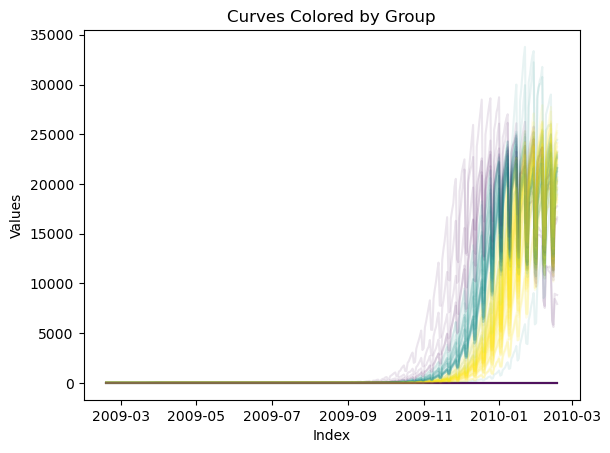

In [135]:
groups = kmeans_result.sort_values('run_id')['CENTROID_ID'].values

unique_groups = np.unique(groups)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_groups)))  # Color map
group_colors = {group: color for group, color in zip(unique_groups, colors)}

for col in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[col].rolling(1).median(), label=f'Column {col}', color=group_colors[groups[col - 1]], alpha=.1)

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Curves Colored by Group')
plt.show()
